# A/B-тест гипотез по увеличению выручки интернет-магазина

Цель настоящего проекта - проанализировать предложения отдела маркетинга интернет-магазина, направленные на увеличение выручки. Предложения сформулированы в виде гипотез. Задача - посредством A/B-тестирования проверить эти гипотезы.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

pd.set_option('display.max_colwidth', None)

In [2]:
try:
    hypothesis = pd.read_csv('hypothesis.csv')
    orders = pd.read_csv('orders.csv')
    visitors = pd.read_csv('visitors.csv')
except:
    hypothesis = pd.read_csv('datasets/hypothesis.csv')
    orders = pd.read_csv('datasets/orders.csv')
    visitors = pd.read_csv('datasets/visitors.csv')

In [3]:
hypothesis.info()
hypothesis.head(9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Датасет hypothesis содержит список из 9 гипотез, для каждой из которых даны оценки параметров Reach, Impact, Confidence и Efforts.

In [4]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Датасет orders содержит список заказов, совершенных посетителями двух тестовых групп, в том числе id заказа и посетителя, дату и стоимость заказа, группу посетителя.

In [5]:
visitors.info()
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Датасет visitors содержит данные о количестве посетителей магазина в каждый день тестового периода.

In [6]:
print(orders['date'].nunique())
print(orders['date'].min())
print(orders['date'].max())

31
2019-08-01
2019-08-31


К настоящему моменту A/B-тест идет 31 день, с 1 по 31.08.2019.

## Предобработка данных

In [7]:
# форматируем названия колонок
hypothesis.rename(
    lambda column_name: column_name.lower(),
    axis='columns',
    inplace=True
)

orders.rename(
    columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'},
    inplace=True
)

In [8]:
# преобразуем тип данных в колонках date с object на datetime
orders['date'] = orders['date'].map(
    lambda dt: pd.to_datetime(dt)
)
visitors['date'] = visitors['date'].map(
    lambda dt: pd.to_datetime(dt)
)

In [9]:
# проверим данные на наличие пропусков
print('количество пропусков в датасете hypothesis:\n', hypothesis.isna().sum(), '\n')
print('количество пропусков в датасете orders:\n', orders.isna().sum(), '\n')
print('количество пропусков в датасете visitors:\n', visitors.isna().sum(), '\n')

количество пропусков в датасете hypothesis:
 hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64 

количество пропусков в датасете orders:
 transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64 

количество пропусков в датасете visitors:
 date        0
group       0
visitors    0
dtype: int64 



Пропущенных значений нет ни в одном датасете.

In [10]:
# проверим данные на наличие дубликатов
print('количество пропусков в датасете hypothesis:\n', hypothesis.duplicated().sum(), '\n')
print('количество пропусков в датасете orders:\n', orders.duplicated().sum(), '\n')
print('количество пропусков в датасете visitors:\n', visitors.duplicated().sum(), '\n')

количество пропусков в датасете hypothesis:
 0 

количество пропусков в датасете orders:
 0 

количество пропусков в датасете visitors:
 0 



Дублированные значения в датасетах также отсутствуют.

In [34]:
orders.query('group == "A"').nunique()

transaction_id    468
visitor_id        445
date               31
revenue           361
group               1
dtype: int64

In [12]:
orders.query('group == "B"').nunique()

transaction_id    640
visitor_id        586
date               31
revenue           450
group               1
dtype: int64

In [13]:
orders.nunique()

transaction_id    1197
visitor_id        1031
date                31
revenue            713
group                2
dtype: int64

In [14]:
# уникальные покупатели в каждой группе
buyers_a = orders.query('group == "A"')['visitor_id'].unique()
buyers_b = orders.query('group == "B"')['visitor_id'].unique()

# покупатели, встречающиеся в обеих группах
cross_buyers = (
    orders.loc[
        orders['visitor_id'].isin(buyers_a) &
        orders['visitor_id'].isin(buyers_b)]
)['visitor_id'].unique()
print('Количество покупателей, находящихся в обеих тестовых группах:', cross_buyers.shape[0])

Количество покупателей, находящихся в обеих тестовых группах: 58


Поскольку 'пересекающиеся' покупатели составляют 5.6% от количества покупателей в целом, возможно исключить данные о них из датасета и продолжить анализ.

In [15]:
orders = orders.query('visitor_id not in @cross_buyers')
orders['visitor_id'].nunique()

973

Мы привели названия столбцов в snake_case формат, а также убедились, что пропуски и дубликаты в полученных данных отсутствуют. В каждой тестовой группе собраны уникальные пользователи.

## Приоритизация гипотез

In [16]:
hypothesis['ICE'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 2)
hypothesis['RICE'] = round(hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 2)

display(hypothesis[['hypothesis', 'ICE']].sort_values(by=['ICE'], ascending=False).reset_index(drop=True))
display(hypothesis[['hypothesis', 'RICE']].sort_values(by=['RICE'], ascending=False).reset_index(drop=True))

,hypothesis,ICE
0,"Запустить акцию, дающую скидку на товар в день рождения",16.20
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
2,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
4,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
5,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
7,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


,hypothesis,RICE
0,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
1,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
2,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
4,"Запустить акцию, дающую скидку на товар в день рождения",16.2
5,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
6,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
7,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Фреймворки ICE и RICE показывают меняют уровень приоритета для одних и тех же гипотез. Например, гипотеза 'Запустить акцию, дающую скидку на товар в день рождения' по ICE набирает 16.2 балла и является самой приоритетной. Но значение 'Reach' этой гипотезы оценено всего в 1 балл и по RICE эта гипотеза оказывается на 5 месте.

Напротив, гипотеза 'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок' по ICE находится на 3 месте и имеет 11.2 балла. По RICE эта гипотеза набирает 112 баллов и уверенно занимает 1 место.

## Анализ A/B-теста

In [17]:
# рассчитаем кумулятивные значения метрик для каждой группы
dates_groups_pairs = orders[['date','group']].drop_duplicates()

orders_aggregated = dates_groups_pairs.apply(
    lambda pair: orders[np.logical_and(orders['date'] <= pair['date'], orders['group'] == pair['group'])]
    .agg({
        'date': 'max',
        'group': 'max',
        'revenue': 'sum',
        'transaction_id': 'nunique',
        'visitor_id': 'nunique'
    }), axis=1
).sort_values(by=['date','group']).reset_index(drop=True)

orders_aggregated.rename(
    columns={'transaction_id': 'orders', 'visitor_id': 'buyers'},
    inplace=True
)

# рассчитаем кумулятивное количество посетителей из датасета visitors
visitors_a = visitors.query('group == "A"')
visitors_a_cum_count = visitors_a.apply(
    lambda entry: visitors[np.logical_and(visitors['date'] <= entry['date'], visitors['group'] == entry['group'])]
    .agg({
        'date': 'max',
        'group': 'max',
        'visitors': 'sum'
    }), axis=1
).sort_values(by=['date'])

visitors_b = visitors.query('group == "B"')
visitors_b_cum_count = visitors_b.apply(
    lambda entry: visitors[np.logical_and(visitors['date'] <= entry['date'], visitors['group'] == entry['group'])]
    .agg({
        'date': 'max',
        'group': 'max',
        'visitors': 'sum'
    }), axis=1
).sort_values(by=['date'])

cum_visitors_count = pd.concat([visitors_a_cum_count, visitors_b_cum_count], ignore_index=True)

# добавим в агрегированные данные количество посетителей в день
orders_aggregated = orders_aggregated.merge(
    cum_visitors_count,
    on=['date', 'group'],
    how='left'
)

cumulative_a = orders_aggregated[orders_aggregated['group']=='A']

cumulative_b = orders_aggregated[orders_aggregated['group']=='B']

### 1. График кумулятивной выручки по группам

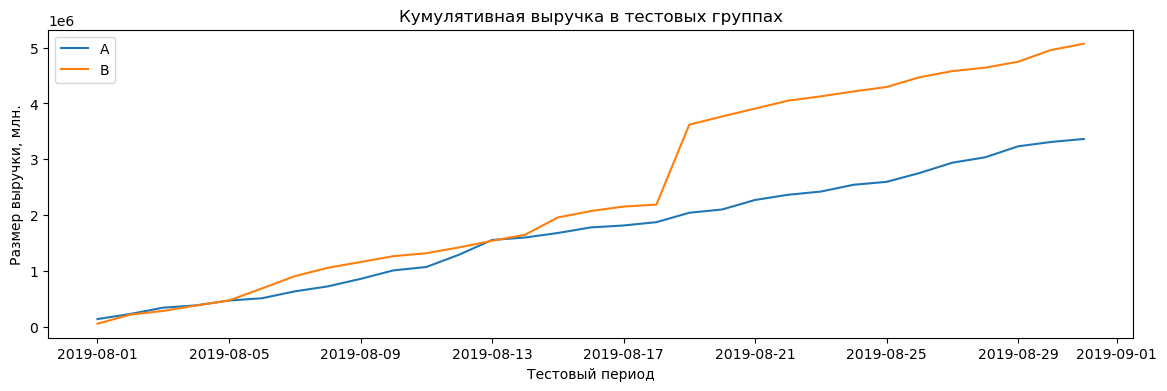

In [18]:
plt.figure(figsize=(14, 4))
plt.plot(cumulative_a['date'], cumulative_a['revenue'], label='A')
plt.plot(cumulative_b['date'], cumulative_b['revenue'], label='B')
plt.title('Кумулятивная выручка в тестовых группах')
plt.legend()
plt.xlabel('Тестовый период')
plt.ylabel('Размер выручки, млн.')

plt.show()

График роста кумулятивной выручки группы A демонстрирует равномерное увеличение. Через несколько дней после начала теста уровень кумулятивной выручки в группе B становится выше, чем в группе A, и остается таким на протяжении всего времени. 18.08.2019 мы видим резкий и значительный рост уровня кумулятивной выручки в группе B. Такой всплеск на графике может быть вызван дорогостоящим заказом, который был сделан в этот день. 

### 2. График кумулятивных средних чеков по группам

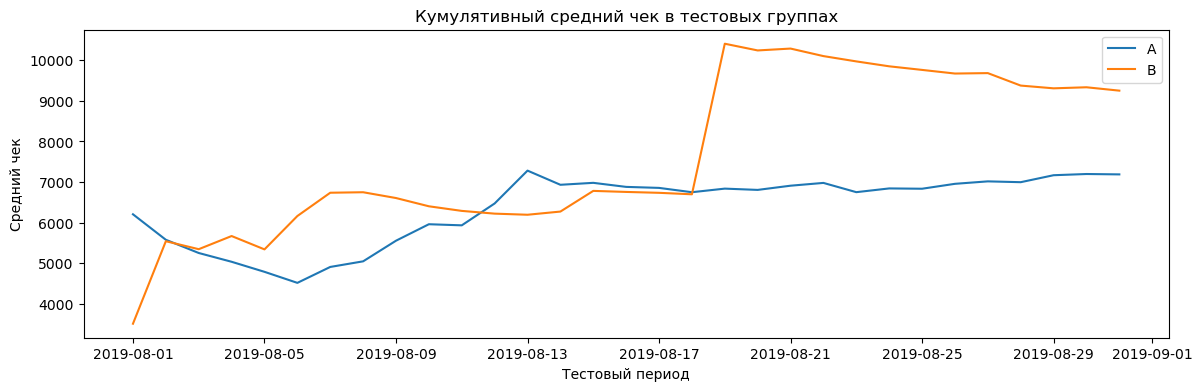

In [19]:
plt.figure(figsize=(14, 4))
plt.plot(
    cumulative_a['date'], cumulative_a['revenue']/cumulative_a['orders'], label='A')
plt.plot(
    cumulative_b['date'], cumulative_b['revenue']/cumulative_b['orders'], label='B')
plt.legend()
plt.legend()
plt.title('Кумулятивный средний чек в тестовых группах')
plt.xlabel('Тестовый период')
plt.ylabel('Средний чек')
plt.show()

На графике мы видим, что для группы А кумулятивный средний чек ко второй половине тестового периода стабилизируется. Средний чек группы B в силу всплеска, наблюдаемого 18.08, за тестовый период стабилизироваться не успевает. Поэтому требуется больше времени, чтобы по построенному графику определить для группы B динамику среднего чека.

<a id='mean_check_relation'></a>
### 3. График относительного изменения кумулятивного среднего чека группы B к группе A

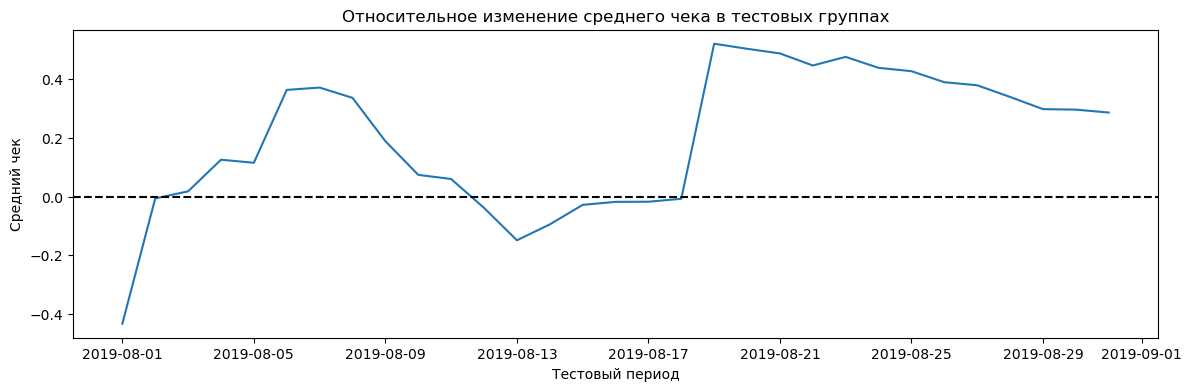

In [20]:
plt.figure(figsize=(14, 4))
merged_cumulative = cumulative_a.merge(
    cumulative_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B']
)

plt.plot(
    merged_cumulative['date'],
    (merged_cumulative['revenueB']/merged_cumulative['ordersB']) / 
    (merged_cumulative['revenueA']/merged_cumulative['ordersA'])-1
)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Относительное изменение среднего чека в тестовых группах')
plt.xlabel('Тестовый период')
plt.ylabel('Средний чек')
plt.show()

График более наглядно, чем предыдущие, показывает несколько резких колебаний, которые, вероятно, вызваны отдельными дорогостоящими покупками в каждой из групп.

### 4. График кумулятивного среднего количества заказов на посетителя по группам

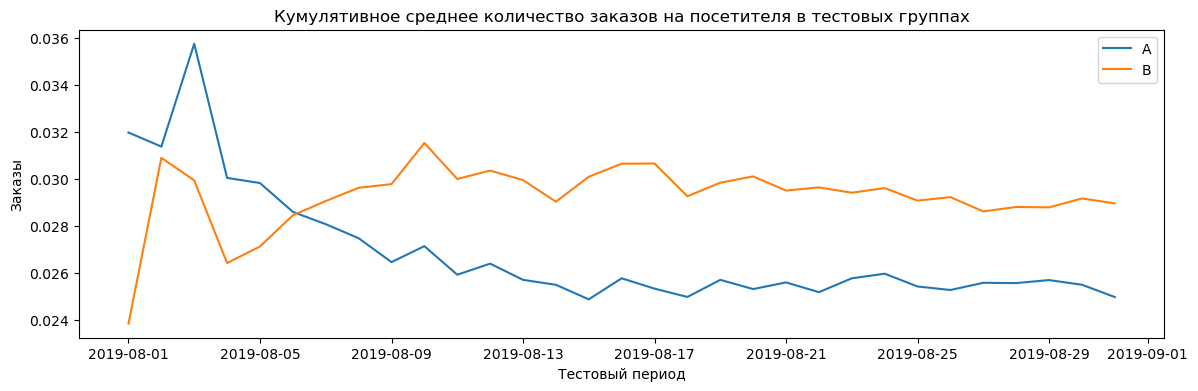

In [21]:
plt.figure(figsize=(14, 4))
plt.plot(
    cumulative_a['date'], cumulative_a['orders']/cumulative_a['visitors'], label='A')
plt.plot(
    cumulative_b['date'], cumulative_b['orders']/cumulative_b['visitors'], label='B')
plt.legend()
plt.title('Кумулятивное среднее количество заказов на посетителя в тестовых группах')
plt.xlabel('Тестовый период')
plt.ylabel('Заказы')
plt.show()

График показывает, что кумулятивное среднее количество заказов на посетителя для группы A стабилизируется на уровне ~0.026. Для группы B это количество стабилизируется на уровне ~0.030. Это позволяет предполагать, что посетители в группе B совершают заказы активнее, чем в группе A.

### 5. График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

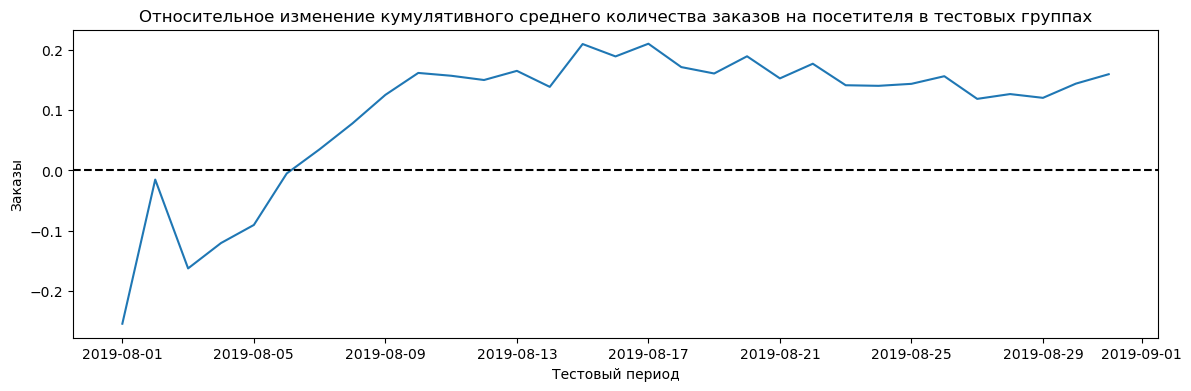

In [22]:
plt.figure(figsize=(14, 4))
plt.plot(
    merged_cumulative['date'],
    (merged_cumulative['ordersB']/merged_cumulative['visitorsB']) / 
    (merged_cumulative['ordersA']/merged_cumulative['visitorsA']) - 1
)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя в тестовых группах')
plt.xlabel('Тестовый период')
plt.ylabel('Заказы')
plt.show()

График постепенно выравнивается, однако, его колебания еще заметны и поэтому нельзя утверждать, что отношение количества заказов на одного посетителя установилось на уровне, соответствующем реальному. 

### 6. График количества заказов по пользователям

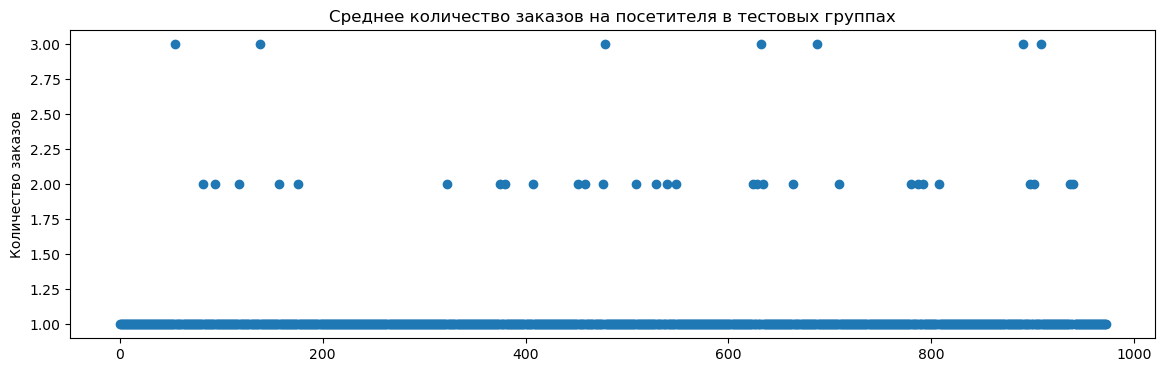

In [23]:
orders_by_user = (
    orders.groupby('visitor_id')
    .agg({
        'transaction_id': 'count',
        'group': 'max'
    })
)

plt.figure(figsize=(14, 4))
plt.scatter(
    range(0, len(orders_by_user['transaction_id'])),
    orders_by_user['transaction_id']
)
plt.title('Среднее количество заказов на посетителя в тестовых группах')
plt.ylabel('Количество заказов')
plt.show()

Большинство посетителей из обеих групп сделало всего по одному заказу. Заметная часть посетителей сделала 2 заказа. Только 7 пользователей сделали 3 заказа.

### 7. Расчет перцентилей количества заказов на пользователя

In [24]:
print(np.percentile(orders_by_user['transaction_id'], [95, 99]))

[1. 2.]


Не более 5% посетителей совершили более 1 зака. Не более 1% посетителей совершили более 2 заказов.

В качестве границы для определения аномальных пользователей выберем 2 заказа на пользователя.

### 8. График стоимостей заказов

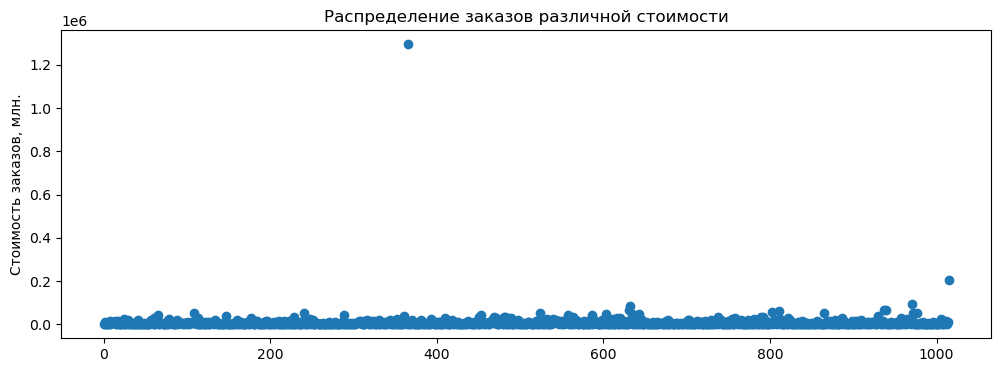

In [25]:
plt.figure(figsize=(12, 4))
plt.scatter(
    range(0, len(orders['revenue'])),
    orders['revenue']
)
plt.title('Распределение заказов различной стоимости')
plt.ylabel('Стоимость заказов, млн.')
plt.show()

График стоимостей заказов демонстрирует, что верхняя граница стоимости большинства заказов ~ 100 000.

Наблюдаются два заказа с аномальной стоимостью в районе 200 000 и 1 300 000.

### 9. Расчет перцентилей стоимостей заказов

In [26]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Только у 5% заказов стоимость превышает 26 785. Только у 1% заказов стоимость превышает 53 904.

В качество границы для определения аномальных заказов выберем 99-й перцентиль, так как это значение позволит оставить в исследуемой выборке большее количество данных, и в то же время удалит из нее явно аномальные значения.

### 10. Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным

##### формулируем первую гипотезу
Нулевая гипотеза: различий в среднем количестве заказов на одного посетителя между группами A и B нет.
Альтернативная гипотеза: различия в среднем количестве заказов между группами A и B есть.

In [27]:
visitors_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a.columns = ['date', 'visitors_by_dt_a']
visitors_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b.columns = ['date', 'visitors_by_dt_b']

# рассчитываем кумулятивное количество посетителей для каждой даты
visitors_a_cummulative = visitors_a.apply(
    lambda x: visitors_a[visitors_a['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_by_dt_a': 'sum'}
    ),
    axis=1
)
visitors_a_cummulative.columns = ['date', 'cum_visitors_by_dt_a']
visitors_b_cummulative = visitors_b.apply(
    lambda x: visitors_b[visitors_b['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_by_dt_b': 'sum'}
    ),
    axis=1
)
visitors_b_cummulative.columns = ['date', 'cum_visitors_by_dt_b']

# рассчитываем количество заказов и выручку для каждой даты
orders_a = (
    orders[orders['group'] == 'A'][['transaction_id', 'visitor_id', 'date', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a.columns = ['date', 'orders_by_dt_a', 'revenue_by_dt_a']

orders_b = (
    orders[orders['group'] == 'B'][['transaction_id', 'visitor_id', 'date', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b.columns = ['date', 'orders_by_dt_b', 'revenue_by_dt_b']

# рассчитываем для каждой группы кумулятивные количество заказов и выручку
orders_a_cummulative = orders_a.apply(
    lambda x: orders_a[orders_a['date'] <= x['date']].agg(
        {'date': 'max', 'orders_by_dt_a': 'sum', 'revenue_by_dt_a': 'sum'}
    ),
    axis=1
).sort_values(by=['date'])
orders_a_cummulative.columns = ['date', 'cum_orders_by_dt_a', 'cum_revenue_by_dt_a']
orders_b_cummulative = orders_b.apply(
    lambda x: orders_b[orders_b['date'] <= x['date']].agg(
        {'date': 'max', 'orders_by_dt_b': 'sum', 'revenue_by_dt_b': 'sum'}
    ),
    axis=1
).sort_values(by=['date'])
orders_b_cummulative.columns = ['date', 'cum_orders_by_dt_b', 'cum_revenue_by_dt_b']

data_by_groups = (
    orders_a.merge(orders_b, left_on='date', right_on='date', how='left')
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a, left_on='date', right_on='date', how='left')
    .merge(visitors_b, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

In [28]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

sample_a = pd.concat(
    [
        orders_by_users_a['orders'],
        pd.Series(
            0,
            index=np.arange(data_by_groups['visitors_by_dt_a'].sum() - len(orders_by_users_a['orders'])),
            name='orders'
        )
    ],
    axis=0
)

sample_b = pd.concat(
    [
        orders_by_users_b['orders'],
        pd.Series(
            0,
            index=np.arange(data_by_groups['visitors_by_dt_b'].sum() - len(orders_by_users_b['orders'])),
            name='orders'
        )
    ],
    axis=0
)

In [29]:
print("{0:.3f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))
print("{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

0.011
0.160


P-value, рассчитанное на 'сырых' данных, ниже 0.05. Это говорит о наличии оснований для отклонения нулевой гипотезы, согласно которой среднее количество заказов в группах не отличается.
Кроме того, мы видим, что среднее количество заказов в группе B выше на 16%.

### 11. Расчет статистической значимости различий в среднем чеке между группами по «сырым» данным

##### формулируем вторую гипотезу
Нулевая гипотеза: различий в среднем чеке между группами нет.
Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [30]:
print('{0:.3f}'.format(
    stats.mannwhitneyu(
        orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue']
    )[1]
))
print('{0:.3f}'.format(
    orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1
))

0.829
0.287


P-value, рассчитанное на 'сырых' данных, значительно выше 0.05. Это говорит об отсутствии оснований для отклонения нулевой гипотезы, согласно которой средний чек в группах не отличается.
Кроме того, мы видим, что средний чек в группе B выше почти на 29%.

### 12. Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Исходя из перцентилей стоимостей заказов и количества заказов на посетителя в качестве аномальных примем посетителей:
- совершивших более 2 заказов
- совершивших заказы, стоимость которых превышает 53 904

In [31]:
# выделим аномальных пользователей
revenue_threshold = 53904
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > 2]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > revenue_threshold]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_users.head(5))
print(abnormal_users.shape[0])

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
Name: visitor_id, dtype: int64
16


Всего в выборке присутствует 16 аномальных посетителей.

##### формулируем первую гипотезу для 'очищенных' данных
Нулевая гипотеза: различий в среднем количестве заказов на одного посетителя между группами A и B нет.
Альтернативная гипотеза: различия в среднем количестве заказов между группами A и B есть.

In [32]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data_by_groups['visitors_by_dt_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data_by_groups['visitors_by_dt_b'].sum() - len(orders_by_users_b['orders'])            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('{0:.3f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print('{0:.3f}'.format(sample_b_filtered.mean() / sample_a_filtered.mean() - 1))

0.007
0.189


P-value, рассчитанное на данных без аномальных значений, еще больше снизилось и по-прежнему ниже 0.05.

Для отфильтрованных выборок группа B опережает группу A по среднему количеству заказов уже более чем на 18%.

Таким образом, отклоним нулевую гипотезу и примем альтернативную гипотезу, согласно которой среднее количество заказов в группах A и B отличается.

### 13. Расчет статистической значимости различий в среднем чеке между группами по «очищенным» данным

##### формулируем вторую гипотезу для 'очищенных' данных
Нулевая гипотеза: различий в среднем чеке между группами нет.
Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [33]:
print('{0:.3f}'.format(
    stats.mannwhitneyu(
        orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'],
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'],
    )[1]
))

print('{0:.3f}'.format(
    orders[
        np.logical_and(
            orders['group'] == 'B',
            np.logical_not(orders['visitor_id'].isin(abnormal_users)),
        )
    ]['revenue'].mean()
    / orders[
        np.logical_and(
            orders['group'] == 'A',
            np.logical_not(orders['visitor_id'].isin(abnormal_users)),
        )
    ]['revenue'].mean() - 1
))

0.788
-0.032


P-value, рассчитанное на данных без аномальных значений, даже незначительно снизилось.

Однако, для отфильтрованных выборок группа B отстает от группы A по среднему чеку на 3%.

### Итоговый вывод

В ходе исследования требовалось оценить, насколько в двух тестовых группах отличаются среднее количество заказов на посетителя и средний чек. Полученные по итогам тестирования данные анализировались как в 'сыром' виде, так и в 'очищенном' от аномальных значений.

1. Была рассчитана статистическая значимость различий в среднем количестве заказов на одного посетителя между группами A и B и сформулированы гипотезы:
Н0: различий в среднем количестве заказов между группами нет.
H1: различия в среднем количестве заказов между группами есть.
alpha = 0.05

p-value на 'сырых' данных = 0.011

p-value на 'очищенных' данных = 0.007

отношение среднего количества заказов в группе B к среднему количеству заказов в группе A:

на 'сырых' данных = 0.160

на 'очищенных' данных = 0.189

Таким образом, мы отклонили нулевую гипотезу и приняли альтернативную гипотезу, согласно которой среднее количество заказов в группах A и B отличается.

2. Была рассчитана статистическая значимость различий в среднем чеке между группами A и B и сформулированы гипотезы:
Н0: различий в среднем чеке между группами нет.
H1: различия в среднем чеке между группами есть.
alpha = 0.05

p-value на 'сырых' данных = 0.829

p-value на 'очищенных' данных = 0.788

отношение среднего чека в группе B к среднему чеку в группе A:

на 'сырых' данных = 0.287

на 'очищенных' данных = -0.032

P-value, рассчитанное и на 'сырых', и на 'очищенных' данных, значительно выше 0.05. Это говорит об отсутствии оснований для отклонения нулевой гипотезы, согласно которой средний чек в группах не отличается.

Кроме того, мы видим, что отношение среднего чека в группе B к среднему чеку в группе A на 'сырых' и 'очищенных' данных существенно отличается. Отношение средних чеков на 'очищенных' данных стремится в выравниванию. 

[График](#mean_check_relation) относительного изменения кумулятивного среднего чека в группах также дает основания говорить, что к настоящему моменту значения средних чеков еще не установились на реальном уровне.

Таким образом, полагаем необходимым продолжить тест до появления непротиворечивых результатов. На продолжение теста возьмем неделю, т.е. 1/4 от уже истекшего тестового периода - этого времени будет достаточно для понимания, стабилизовались ли полученные результаты.